# Load the data

In [1]:
import json


DEVICE = 'ibm_sherbrooke'
STATE = 'X0'
ROUNDS = 50

file_name = f'./results/{DEVICE}_{STATE}_{ROUNDS}.json'



In [21]:
with open(file_name, 'r') as f:
    data = json.load(f)

print('num_jobs', len(data))

# Transform data
err_dict = {}

for job_id, job_content in data.items():
    for distance, methods in job_content.get("distances", {}).items():
        for method, info in methods.items():
            if method == 'tot_shots_with_all_subsets':
                tot_shots = int(info)
                continue
            if method not in err_dict:
                err_dict[method] = {}
            if distance not in err_dict[method]:
                err_dict[method][int(distance)] = { 'tot_shots': [], 'sum_errs': [], 'err_rates': [], }
            err_dict[method][int(distance)]['tot_shots'].append(tot_shots)
            err_dict[method][int(distance)]['err_rates'].append(info['err_rate'])
            err_dict[method][int(distance)]['sum_errs'].append(info['sum_errs'])
            # method_dist_err_dict[method][distance].append(info['err_rate'])

# print(json.dumps(method_dist_err_dict, indent=4))

# Calculate mean error rates
for method, distances in err_dict.items():
    for distance, data in distances.items():
        sum_tot_shots = sum(data['tot_shots'])
        sum_err_rate = sum(data['err_rates']) 
        sum_sum_errs = sum(data['sum_errs']) 

        err_dict[method][distance]['sum_tot_shots'] = sum_tot_shots
        err_dict[method][distance]['sum_err_rate'] = sum_err_rate
        err_dict[method][distance]['sum_sum_errs'] = sum_sum_errs

# Print result
print(err_dict)

num_jobs 1
{'s_K': {51: {'tot_shots': [3014], 'sum_errs': [0.0], 'err_rates': [0.0], 'sum_tot_shots': 3014, 'sum_err_rate': 0.0, 'sum_sum_errs': 0.0}, 49: {'tot_shots': [6028], 'sum_errs': [0.0], 'err_rates': [0.0], 'sum_tot_shots': 6028, 'sum_err_rate': 0.0, 'sum_sum_errs': 0.0}, 47: {'tot_shots': [9042], 'sum_errs': [0.0], 'err_rates': [0.0], 'sum_tot_shots': 9042, 'sum_err_rate': 0.0, 'sum_sum_errs': 0.0}, 45: {'tot_shots': [12056], 'sum_errs': [0.0], 'err_rates': [0.0], 'sum_tot_shots': 12056, 'sum_err_rate': 0.0, 'sum_sum_errs': 0.0}, 43: {'tot_shots': [15070], 'sum_errs': [0.0], 'err_rates': [0.0], 'sum_tot_shots': 15070, 'sum_err_rate': 0.0, 'sum_sum_errs': 0.0}, 41: {'tot_shots': [18084], 'sum_errs': [0.0], 'err_rates': [0.0], 'sum_tot_shots': 18084, 'sum_err_rate': 0.0, 'sum_sum_errs': 0.0}, 39: {'tot_shots': [21098], 'sum_errs': [0.0], 'err_rates': [0.0], 'sum_tot_shots': 21098, 'sum_err_rate': 0.0, 'sum_sum_errs': 0.0}, 37: {'tot_shots': [24112], 'sum_errs': [0.0], 'err_rate

# Plotting

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

from scipy.optimize import curve_fit

def wilson_score_interval(p, n, z=1.96):
    """
    Calculate Wilson score interval for a given success probability (p), number of trials (n), and z-score (z).
    """
    denominator = 1 + z**2 / n
    term = z * np.sqrt(p * (1 - p) / n + z**2 / (4 * n**2))
    lower = (p + z**2 / (2 * n) - term) / denominator
    upper = (p + z**2 / (2 * n) + term) / denominator
    return max(lower, 0), min(upper, 1)


def logical_err_rate_per_round(p, T):
    return (1-np.exp(1/T * np.log(1-2*p)))/2


def lambda_func(d, C, Lambda):
    return C * Lambda ** (-(d+1)/2)


def plot_error_rates(distances, errs, shots, label, color='black'):
    """
    Plot error rates with confidence intervals.

    Parameters:
    - distances: List of distances.
    - errs: List of error rates corresponding to the distances.
    - shots: Number of shots corresponding to each error rate.
    - label: Label for the plot legend.
    - color: (Optional) Color for the plot.
    """
    # Setup plot parameters for PRX style
    FIGURE_WIDTH_1COL = 3.404
    FIGURE_HEIGHT_1COL_GR = FIGURE_WIDTH_1COL * 2 / (1 + np.sqrt(5)) * 1.1
    font_size = 6

    plt.rcParams.update({
        'font.size': font_size,
        'figure.titlesize': 'medium',
        'figure.dpi': 1000,
        'figure.figsize': (FIGURE_WIDTH_1COL, FIGURE_HEIGHT_1COL_GR),
        'axes.titlesize': 'medium',
        'axes.axisbelow': True,
        'xtick.direction': 'in',
        'xtick.labelsize': 'small',
        'ytick.direction': 'in',
        'ytick.labelsize': 'small',
        'image.interpolation': 'none',
        'legend.fontsize': font_size,
        'axes.labelsize': font_size,
        'axes.titlesize': font_size,
        'xtick.labelsize': font_size,
        'ytick.labelsize': font_size,
        'font.family': 'sans-serif',
    })

    # Calculate Wilson score intervals for confidence
    lowers = []
    uppers = []
    ps = []
    for err_nb, n in zip(errs, shots):
        p = err_nb / n
        lower, upper = wilson_score_interval(p, n)
        ps.append(p)
        lowers.append(lower)
        uppers.append(upper)

    # Plot error rates and confidence intervals
    plt.plot(distances, ps, label=label, marker='o', color=color, markersize=2, linewidth=1)
    plt.fill_between(distances, lowers, uppers, color='black', alpha=0.1)

    plt.yscale("log")
    plt.ylabel('Logical Error Rate')
    plt.xlabel('Distance')
    plt.grid(True, which="both", linestyle='--', linewidth=0.2)
    plt.xticks(distances[::2])
    # plt.yticks(ticks=[0.0001, 0.001, 0.01, 0.1], labels=["0.01%", "0.1%", "1%", "10%"])
    plt.legend(fontsize=3)


/var/folders/_3/n7zzdff5239886c9gmhrk6yr0000gn/T/ipykernel_45423/1125019216.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('Dark2', num_methods)


s_K
h_K
h_K_mean
s_KPS
h_KPS
h_K_meanPS


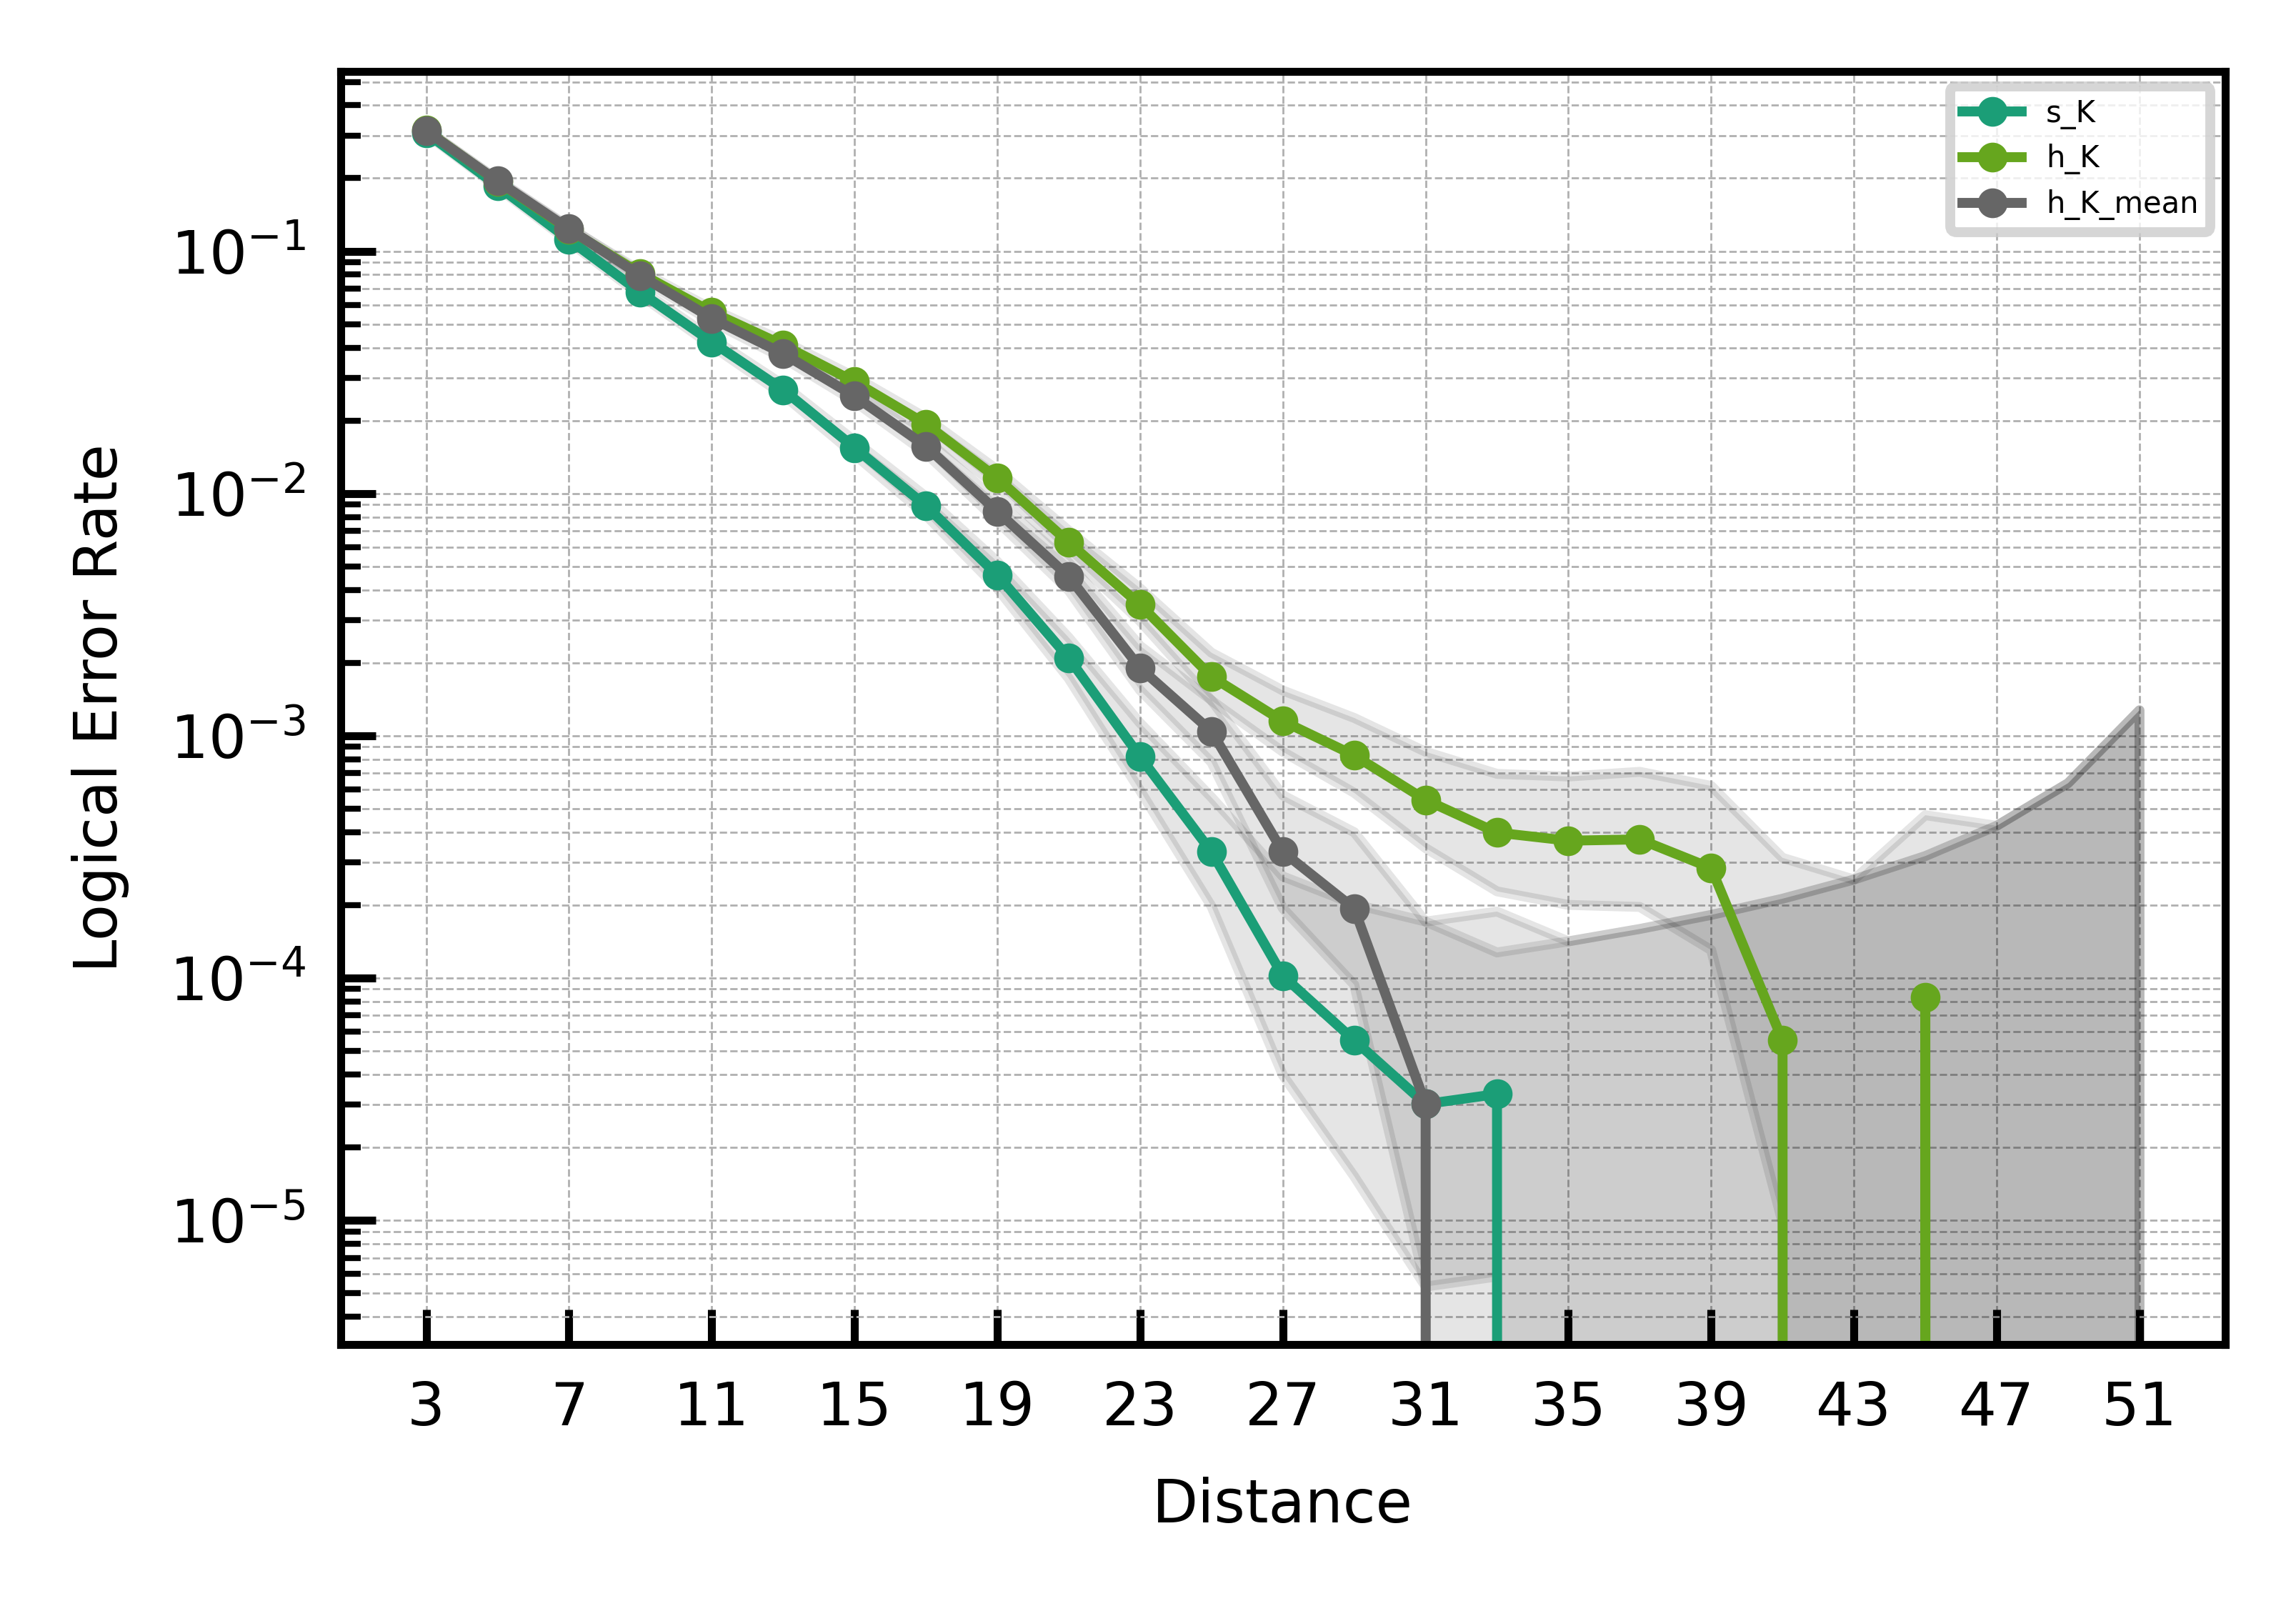

In [20]:
import matplotlib.pyplot as plt
from matplotlib import cm

# Criteria for inclusion and exclusion
# to_skip = ['indiv', 'PS', 'mean_50', 'mean_mean', 'soft']
# to_have = ['kde']
to_skip = ['PS']
to_have = ['s_K', 'h_K']

num_methods = sum(not any(x in method for x in to_skip) and any(x in method for x in to_have) for method in err_dict.keys())
colors = cm.get_cmap('Dark2', num_methods)
current_method_index = 0
for i, (method, dist_dict) in enumerate(err_dict.items()):
    print(method)
    if not any(x in method for x in to_have) or any(x in method for x in to_skip):
        continue

    distances = list(dist_dict.keys())[::-1]
    errs = [v['mean_sum_errs'] for v in dist_dict.values()][::-1]
    nb_shots = [v['tot_shots'] for v in dist_dict.values()][::-1]


    color = colors(current_method_index / (num_methods ))
    plot_error_rates(distances, errs, nb_shots, label=method, color=color)

    current_method_index += 1

